# SensorThings API – Live-Datenzugriff und Visualisierung

Dieses Notebook demonstriert den Zugriff auf standardisierte Umweltdaten im SensorThings-Format – basierend auf den Messstationen des Projekts *Smart Urban Heat Map* (Bern, CH).

Die Daten werden **live über eine REST-API** abgefragt, die den SensorThings-Standard des Open Geospatial Consortium (OGC) implementiert. Die zugrunde liegende API wurde im Projekt entwickelt und auf PythonAnywhere gehostet.

## Importierte Python-Bibliotheken

- `requests`: HTTP-Anfragen an Web-APIs
- `pandas`: Datenverarbeitung in Tabellenform
- `geopandas`: Geodatenverarbeitung mit Geometrien
- `folium`: Interaktive Kartenanzeige
- `matplotlib.pyplot`: Visualisierung von Zeitreihen
- `branca.colormap`: Farbskalen für Karten

In [1]:
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
import branca.colormap as cm
import matplotlib.pyplot as plt

## Abruf aktueller Sensordaten über die SensorThings-API

Wir rufen aktuelle Messwerte im SensorThings-Format über den `/latest`-Endpunkt der entwickelten API ab.

Dies entspricht semantisch den Temperatur- und Luftfeuchtewerten, die über die ursprüngliche GeoJSON-API bereitgestellt wurden – nun aber standardkonform strukturiert.

In [2]:
url = "https://lenobach.pythonanywhere.com/latest"
response = requests.get(url)
data = response.json()

# Display the response status code
response

<Response [200]>

## Strukturierte Darstellung der SensorThings-Entitäten

Die API liefert strukturierte JSON-Objekte für die vier zentralen SensorThings-Komponenten:

- **Things**: Physikalische Objekte, z. B. Wetterstationen
- **Locations**: Geografische Koordinaten der Things
- **Datastreams**: Zuordnung zwischen Sensor, Messgrösse und Thing
- **Observations**: Einzelne Messwerte mit Zeitstempel

Wir wandeln diese Daten in pandas-DataFrames um und zeigen ein Beispiel je Komponente.

In [3]:
# Wandeln die SensorThings-Komponenten in DataFrames um
things = pd.json_normalize(data["Things"])
locations = pd.json_normalize(data["Locations"])
datastreams = pd.json_normalize(data["Datastreams"])
observations = pd.json_normalize(data["Observations"])

# Anzeigen aller vier Komponenten zur Validierung
print("\n Things:")
display(things.head(1))

print("\n Locations:")
display(locations.head(1))

print("\n Datastreams:")
display(datastreams.head(2))

print("\n Observations:")
display(observations.head(2))


 Things:


,@iot.id,description,name,properties.measurementsPlausible,properties.outdated
0,11117,Sensor station measuring temperature and humidity,Ittigen Papiermühle Kreisel,True,False



 Locations:


,@iot.id,description,encodingType,name,location.coordinates,location.type
0,11117,Geographic location of the sensor,application/vnd.geo+json,Ittigen Papiermühle Kreisel,"[7.477217, 46.974644]",Point



 Datastreams:


,@iot.id,description,name,observationType,ObservedProperty.definition,ObservedProperty.name,Sensor.description,Sensor.name,Thing.@iot.id,unitOfMeasurement.definition,unitOfMeasurement.name,unitOfMeasurement.symbol
0,11117-temperature,Temperature measurements,Temperature Datastream for Ittigen Papiermühle...,http://www.opengis.net/def/observationType/OGC...,http://sensorthings.org/Temperature,Temperature,Measures air temperature,Temperature Sensor,11117,http://unitsofmeasure.org/ucum.html#para-30,Degree Celsius,°C
1,11117-humidity,Humidity measurements,Humidity Datastream for Ittigen Papiermühle Kr...,http://www.opengis.net/def/observationType/OGC...,http://sensorthings.org/Humidity,Humidity,Measures relative humidity,Humidity Sensor,11117,http://unitsofmeasure.org/ucum.html#para-30,Percentage,%



 Observations:


,phenomenonTime,result,resultTime,Datastream.@iot.id
0,2025-06-17T22:09:58Z,19.256123,2025-06-17T22:09:58Z,11117-temperature
1,2025-06-17T22:09:58Z,62.942170,2025-06-17T22:09:58Z,11117-humidity


## Interaktive Standortkarte mit Temperatur- und Feuchtewerten

Die folgenden Schritte extrahieren aktuelle Temperatur- und Luftfeuchtewerte, verknüpfen sie mit den Sensorstandorten und visualisieren sie auf einer interaktiven Karte.

- Die Farbskala basiert auf der Temperatur (°C)
- Luftfeuchtigkeit (%) wird im Tooltip zusätzlich angezeigt
- Darstellung entspricht visuell dem `python_examples`-Notebook der ursprünglichen Smart Urban Heat Map API

In [4]:
# Temperatur-Observationen
obs_temp = observations[observations["Datastream.@iot.id"].str.contains("temperature")].copy()
obs_temp["stationId"] = obs_temp["Datastream.@iot.id"].str.replace("-temperature", "", regex=False)
obs_temp = obs_temp[["stationId", "result"]].rename(columns={"result": "temperature"})

# Feuchtigkeits-Observationen
obs_hum = observations[observations["Datastream.@iot.id"].str.contains("humidity")].copy()
obs_hum["stationId"] = obs_hum["Datastream.@iot.id"].str.replace("-humidity", "", regex=False)
obs_hum = obs_hum[["stationId", "result"]].rename(columns={"result": "humidity"})

# Locations vorbereiten
locations["stationId"] = locations["@iot.id"].astype(str)
locations["lon"] = locations["location.coordinates"].apply(lambda x: x[0])
locations["lat"] = locations["location.coordinates"].apply(lambda x: x[1])

# Kombinieren
stations_df = pd.merge(locations, obs_temp, on="stationId", how="left")
stations_df = pd.merge(stations_df, obs_hum, on="stationId", how="left")

# GeoDataFrame erzeugen
geometry = [Point(xy) for xy in zip(stations_df["lon"], stations_df["lat"])]
stations = gpd.GeoDataFrame(stations_df, geometry=geometry, crs="EPSG:4326")

# Karte vorbereiten
m = folium.Map(location=[stations.geometry.y.mean(), stations.geometry.x.mean()], zoom_start=13)

# Farbskala: basiert auf Temperatur
def reversed_colormap(existing):
    return cm.LinearColormap(
        colors=list(reversed(existing.colors)),
        vmin=existing.vmin, vmax=existing.vmax
    )

colormap = reversed_colormap(cm.linear.Spectral_04)
colormap = colormap.scale(15, 37).to_step(9)
colormap.caption = "Temperature (°C)"
colormap.add_to(m)

# Marker mit Temperatur + Luftfeuchtigkeit
for idx, station in stations.iterrows():
    if pd.notnull(station["temperature"]):
        tooltip_text = f"{station['name']}<br>" \
                       f"{station['temperature']:.2f} °C<br>" \
                       f"{station['humidity']:.1f} %"
        folium.CircleMarker(
            location=(station.geometry.y, station.geometry.x),
            radius=5,
            color="black",
            weight=0.5,
            fill=True,
            fill_color=colormap(station['temperature']),
            fill_opacity=1,
            tooltip=tooltip_text
        ).add_to(m)

# Karte anzeigen
m

## Zeitreihenabfrage für eine bestimmte Station

Wir rufen historische Messwerte (Temperatur und Luftfeuchtigkeit) für eine ausgewählte Station im SensorThings-Format ab – über den `/timeseries`-Endpunkt.

Die Parameter (`stationId`, `timeFrom`, `timeTo`) werden direkt als Query-Parameter übergeben.

In [5]:
# Hole die stationId für einen bekannten Namen (aus stations GeoDataFrame von vorher)
stationId = stations[stations["name"] == "Ittigen Papiermühle Kreisel"]["stationId"].values[0]

# SensorThings API: URL aufrufen mit Zeitbereich
url_sta = f"https://lenobach.pythonanywhere.com/timeseries?stationId={stationId}&timeFrom=2024-11-01T00:00:00Z&timeTo=2024-11-05T00:00:00Z"
response_sta = requests.get(url_sta)

# Zeige HTTP Status
response_sta

<Response [200]>

### Anzeige der API-Antwort (JSON)

Zur Kontrolle zeigen wir den Anfang der JSON-Payload aus dem API-Response.

In [6]:
# Zeige die ersten 400 Zeichen des JSON (zur groben Kontrolle)
response_sta.text[:400]

'{"Observations":[{"Datastream":{"@iot.id":"11117-temperature"},"phenomenonTime":"2024-11-01T00:24:02+00:00","result":11.018158,"resultTime":"2024-11-01T00:24:02+00:00"},{"Datastream":{"@iot.id":"11117-humidity"},"phenomenonTime":"2024-11-01T00:24:02+00:00","result":76.09926,"resultTime":"2024-11-01T00:24:02+00:00"},{"Datastream":{"@iot.id":"11117-temperature"},"phenomenonTime":"2024-11-01T00:44:02'

### Strukturierte Darstellung der Zeitreihendaten

Die API liefert alle Beobachtungen (`Observations`) als JSON. Wir laden sie in ein DataFrame und trennen Temperatur- und Feuchtewerte für die anschliessende Visualisierung.

In [7]:
# Lade JSON zu Observations
data_sta = response_sta.json()
observations_sta = pd.json_normalize(data_sta["Observations"])

# Konvertiere Zeitstempel
observations_sta["phenomenonTime"] = pd.to_datetime(observations_sta["phenomenonTime"])

# Trenne Temperatur / Luftfeuchte
temp_sta = observations_sta[observations_sta["Datastream.@iot.id"].str.contains("temperature")].copy()
hum_sta = observations_sta[observations_sta["Datastream.@iot.id"].str.contains("humidity")].copy()

# Anzeigen

print("\n temperatur:")
display(temp_sta.head(5))

print("\n humidity:")
display(hum_sta.head(5))


 temperatur:


,phenomenonTime,result,resultTime,Datastream.@iot.id
0,2024-11-01 00:24:02+00:00,11.018158,2024-11-01T00:24:02+00:00,11117-temperature
2,2024-11-01 00:44:02+00:00,10.980774,2024-11-01T00:44:02+00:00,11117-temperature
4,2024-11-01 01:04:02+00:00,10.700389,2024-11-01T01:04:02+00:00,11117-temperature
6,2024-11-01 01:24:02+00:00,10.363928,2024-11-01T01:24:02+00:00,11117-temperature
8,2024-11-01 01:34:02+00:00,10.454719,2024-11-01T01:34:02+00:00,11117-temperature



 humidity:


,phenomenonTime,result,resultTime,Datastream.@iot.id
1,2024-11-01 00:24:02+00:00,76.099260,2024-11-01T00:24:02+00:00,11117-humidity
3,2024-11-01 00:44:02+00:00,76.421610,2024-11-01T00:44:02+00:00,11117-humidity
5,2024-11-01 01:04:02+00:00,76.330055,2024-11-01T01:04:02+00:00,11117-humidity
7,2024-11-01 01:24:02+00:00,76.988100,2024-11-01T01:24:02+00:00,11117-humidity
9,2024-11-01 01:34:02+00:00,76.652400,2024-11-01T01:34:02+00:00,11117-humidity


## Zeitverlauf: Temperaturmessungen

Die gemessenen Temperaturen der Station werden als Zeitreihe dargestellt.

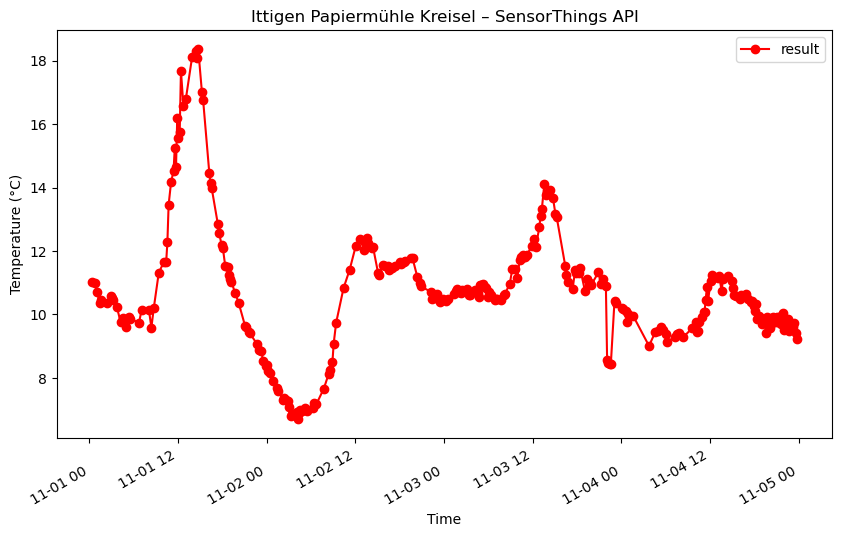

In [8]:
# Temperatur-Zeitreihe
ax = temp_sta.plot(x="phenomenonTime", y="result", figsize=(10,6), marker="o", linestyle="-", color="red")
ax.set_title("Ittigen Papiermühle Kreisel – SensorThings API")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature (°C)")

# X-Achse lesbarer machen
for i, label in enumerate(ax.get_xticklabels()):
    if i % 2 == 0:
        label.set_y(-0.04)

## Zeitreihen-Darstellung mit Doppelskala

In dieser kombinierten Visualisierung zeigen wir:

- Temperatur (°C) auf der linken Y-Achse
- Relative Luftfeuchtigkeit (%) auf der rechten Y-Achse

Das Layout entspricht dem ursprünglichen Notebook `python_examples.ipynb` welches von Smart Urban Heat Map zur verfügung gestellt wird.

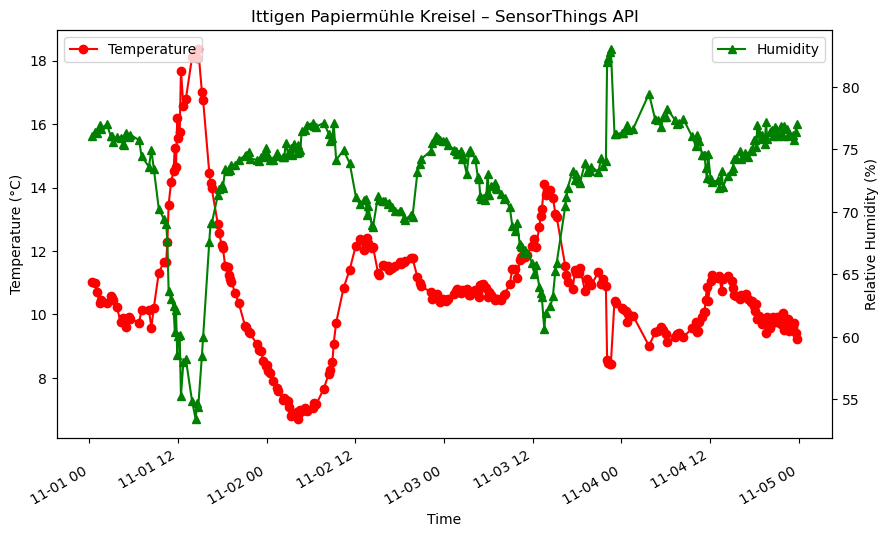

In [9]:
# Temperatur plotten
ax = temp_sta.plot(x="phenomenonTime", y="result", figsize=(10,6), marker="o", linestyle="-", color="red")

# Zweite Achse für Luftfeuchtigkeit
ax2 = ax.twinx()
hum_sta.plot(x="phenomenonTime", y="result", ax=ax2, color="green", marker="^", linestyle="-")

# Achsenbeschriftung
ax.set_title("Ittigen Papiermühle Kreisel – SensorThings API")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature (°C)")
ax2.set_ylabel("Relative Humidity (%)")

# Legenden platzieren
ax.legend(["Temperature"], loc="upper left")
ax2.legend(["Humidity"], loc="upper right")

# X-Achse optimieren
for i, label in enumerate(ax.get_xticklabels()):
    if i % 2 == 0:
        label.set_y(-0.04)